In [1]:
import pandas as pd
import numpy as np
import tweepy 
import json
import requests

## Data Gathering
### WeRateDogs' Twitter Archive

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Image Prediction File

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_prediction = requests.get(url, allow_redirects = True) 
open('image_predictions.tsv', 'wb').write(image_prediction.content)

335079

In [4]:
image_prediction = pd.read_csv('image_predictions.tsv', sep = '\t')
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Twitter API

<i><b>Note:</b>
\
I had tried to query the data directly from Twitter API several times using several different techniques, yet none of them worked. Therefore, in this part, I will be using the file provided by Udacity (`tweet-json.txt`).</i>

In [5]:
tweet_details = pd.read_json(open("tweet-json.txt", "r", encoding = "utf8"), lines = True)
tweet_details.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [6]:
# selecting only the column of the tweet IDs, retweet counts, favorite counts, and tweet type (original or retweet)

tweet_info = tweet_details[['id', 'retweet_count', 'favorite_count', 'retweeted_status']]
tweet_info.head()

,id,retweet_count,favorite_count,retweeted_status
0,892420643555336193,8853,39467,NaN
1,892177421306343426,6514,33819,NaN
2,891815181378084864,4328,25461,NaN
3,891689557279858688,8964,42908,NaN
4,891327558926688256,9774,41048,NaN


## Data Assessment
### Visual Assessment
#### 1. WeRateDogs' Twitter Archive on `twitter-archive-enhanced.csv`

In [7]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


The data that would be analyzed was only of tweets that were not retweets, and therefore I had to filter the data based on their retweet status. I found that `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` columns in this table were all identifying whether a tweet is an original tweet or a retweet. However, I would not be using these columns as I also had `retweeted_status` column in `tweet_info` table, which I perceived as more straightforward. 
\
\
`in_reply_to_status_id` and `in_reply_to_user_id` columns were not needed as well since I did not wish to identify whether or not a tweet is a reply to an existing tweet. Also, seeing how I had both the rating numerator and denominator, I thought it would be a good idea to replace these two columns with only one column by calculating the final ratings.

#### 2. Image prediction file on `image_predictions.tsv`

In [8]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


From visual assessment alone, it could be seen that the format of the prediction result columns (`p1`, `p2`, and `p3`) were inconsistent as some of the values used sentence case while others used all lowercases. Moreover, these columns could be simplified into a single column by selecting the prediction result with the highest confidence factor. 

#### 3. Tweet details from Twitter API on `tweet-json.txt` 

In [9]:
tweet_info

,id,retweet_count,favorite_count,retweeted_status
0,892420643555336193,8853,39467,NaN
1,892177421306343426,6514,33819,NaN
2,891815181378084864,4328,25461,NaN
3,891689557279858688,8964,42908,NaN
4,891327558926688256,9774,41048,NaN
...,...,...,...,...
2349,666049248165822465,41,111,NaN
2350,666044226329800704,147,311,NaN
2351,666033412701032449,47,128,NaN
2352,666029285002620928,48,132,NaN




### Programmatic Assessment
#### 1. WeRateDogs' Twitter Archive on `twitter-archive-enhanced.csv` 

<b>Checking each column's data type:</b>

In [10]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Despite being numeric, subjecting the values of `tweet_id` column to any mathematical operation would not result in anything useful, and therefore I would argue that the better type for these data would be string, not integer.
\
\
<b>Checking duplicated values:</b>

In [11]:
twitter_archive.duplicated().sum()

0

<b>Checking the values of the dog stage columns:</b>

In [12]:
np.unique(twitter_archive[['doggo', 'floofer', 'pupper', 'puppo']].values)

array(['None', 'doggo', 'floofer', 'pupper', 'puppo'], dtype=object)

The values of the dog state columns (`doggo`, `floofer`, `pupper`, and `puppo`) were either <i>"None"</i> when it was not the dog's stage (or the dog's stage was not recorded) or the stage name itself when it was the right one (e.g., the word <i>"doggo"</i> on the `doggo` column when the dog was a doggo), which was quite impractical and made the columns redundant.

In [13]:
# checking records with multiple dog stages 

stage_check = twitter_archive['doggo'].replace('None', '') + twitter_archive['floofer'].replace('None', '') + twitter_archive['pupper'].replace('None', '') + twitter_archive['puppo'].replace('None', '')
stage_check.value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
dtype: int64

<b>Checking the formatting of the `name` column's values:</b>

In [14]:
dog_name = []

for name in twitter_archive['name']:
    lowercase = name.istitle()
    dog_name.append(lowercase)
    
dog_name.count(True)

2241

From my visual assessment, I assumed that the dog names were supposed to be in sentence case. However, it turned out that there were only 2,241 values (out of the total 2,356 values) that were stored in sentence case.

In [15]:
# checking on the values that were in upper case

uppercase_name = [y for x in twitter_archive['name'] for y in x.split() if y.isupper()]
uppercase_name

['O', 'JD']

In [16]:
# checking on the values that were in lower case

lowercase_name = [y for x in twitter_archive['name'] for y in x.split() if y.islower()]
lowercase_name

['such',
 'a',
 'quite',
 'quite',
 'quite',
 'not',
 'one',
 'incredibly',
 'a',
 'mad',
 'an',
 'very',
 'a',
 'very',
 'just',
 'my',
 'one',
 'not',
 'his',
 'one',
 'a',
 'a',
 'a',
 'an',
 'very',
 'actually',
 'a',
 'just',
 'getting',
 'mad',
 'very',
 'this',
 'unacceptable',
 'all',
 'a',
 'old',
 'a',
 'infuriating',
 'a',
 'a',
 'a',
 'an',
 'a',
 'a',
 'very',
 'getting',
 'just',
 'a',
 'the',
 'the',
 'actually',
 'by',
 'a',
 'officially',
 'a',
 'the',
 'the',
 'a',
 'a',
 'a',
 'a',
 'life',
 'a',
 'one',
 'a',
 'a',
 'a',
 'light',
 'just',
 'space',
 'a',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'an',
 'a',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'quite',
 'a',
 'an',
 'a',
 'an',
 'the',
 'the',
 'a',
 'a',
 'an',
 'a',
 'a',
 'a',
 'a']

<i><b>Note:</b> the code above was referred to [this Stack Overflow thread](https://stackoverflow.com/questions/63358767/how-to-filter-rows-and-words-in-lower-case-in-pandas-dataframe?rq=1).</i>
\
\
The names that were in upper case looked normal, but the names that were in lower case did not look like dog names to me--more like parts of the tweets that were accidentally read as the dogs' names in the scraping process. I would considere these cases as the dogs being not named. 
\
\
<b>Checking the dog rating numerator columns:</b>

In [17]:
num = twitter_archive.rating_numerator.dtype
denom = twitter_archive.rating_denominator.dtype
print (num, denom)

int64 int64


In [18]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [19]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

<b> 2. Image prediction file on `image_predictions.tsv` </b>

In [20]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
image_prediction.duplicated().sum()

0

<b> 3. Tweet details from Twitter API on `tweet-json.txt`</b>

In [22]:
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2354 non-null   int64 
 1   retweet_count     2354 non-null   int64 
 2   favorite_count    2354 non-null   int64 
 3   retweeted_status  179 non-null    object
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


### Assessment Result
According to both visual and programmatic assessments I had conducted, below are the issues found in all of the three tables:
#### Tidiness 

1. All of the three datasets contained the details of the same objects, i.e., WeRateDogs' tweets, and therefore could be merged into a single table. However, the number of each table's entries did not match one another, indicating missing data for several records (to be detected once the tables are merged) 
2. Impractical and redundant data on the dog stage columns (`doggo`, `floofer`, `pupper`, and `puppo`) in `twitter_archive` table


#### Quality
1. Unnecessary columns in `twitter_archive` table:
    - `retweeted_status_id`
    - `retweeted_status_user_id`
    - `retweeted_status_timestamp`
    - `in_reply_to_status_id`
    - `in_reply_to_user_id`<br><br>
<i>Note: these columns also had incorrect data types as they were stored as integer when they should be strings. However, as I found them unnecessary and would later be dropped, this issue would not be fixed.</i><br><br>
2. Records of tweets that were not original tweets (retweets)
3. `rating_numerator` and `rating_denominator` columns in `twitter_archive` table could be transformed into a single (new) column by calculating the final ratings
4. Erroneous data type: 
    - `tweet_id` column in `twitter_archive` and `image_prediction` tables and `id` column in `tweet_data` table (integer, should be string)
    - `timestamp` column in `twitter_archive` table (object, should be datetime)
    - `rating_numerator` and `rating_denominator` in `titter_archive` table (integer, should be float)
    - `retweet_count` and `favorite_count` columns in `tweet_info` table (float, should be integer)
5. Dog names in `twitter_archive` table (`name` column) consisted of invalid values, particularly the ones that were in all-lowercases 
6. Records with more than one dog stage data
7. Inconsistent formatting: 
    - `name` column in `twitter_archive` table
    - Prediction result columns (`p1`, `p2`, `p3`) in `image_prediction` table
8. Multiple data of dog breed prediction results in `image_prediction` table, would need a single column to document the chosen results

## Data Cleaning
During the cleaning process, I would be using the copies of the uncleaned tables generated using the following code:

In [23]:
# copying the uncleaned data 

df_archive = twitter_archive.copy()
df_prediction = image_prediction.copy()
df_info = tweet_info.copy()

# Define: Cleaning Steps
1. Merging all the three tables (Tidiness Issue #1)
2. Dropping the records of tweets that were not original tweets (Quality Issue #2)
3. Creating a new column for final ratings (Quality Issue #3 and #4)
4. Creating a new column for dog stages (Tidiness Issue #2)
5. Creating a new column for dog breeds (Quality Issue #8)
6. Dropping unnecessary columns (Tidiness Issue #2 and Quality Issue #1 and #8)
7. Converting columns with incorrect data types (Quality Issue #4)
8. Fixing columns with inconsistent formatting (Quality Issue #7)
9. Storing the clean data 

### Code & Test: Cleaning Process
#### 1. Merging all the three tables (Tidiness Issue #1)
To merge all the three tables, I would be using `tweet_id` column as the primary key, and therefore had to rename the `id` column in `df_info` table.

In [24]:
# renaming `id` column

df_info = df_info.rename(columns = {'id': 'tweet_id'})

In [25]:
# merging the tables 

from functools import reduce

tweet_data = [df_archive, df_prediction, df_info]
df = reduce(lambda left, right: pd.merge(left, right, on = ['tweet_id'], 
                                         how = 'outer'), tweet_data)

<i><b>Note:</b> the codes above was reffered to [this Stack Overflow thread](https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes). 

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [27]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,retweeted_status
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,8853.0,39467.0,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.090647,True,papillon,0.068957,True,6514.0,33819.0,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.031379,True,4328.0,25461.0,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964.0,42908.0,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774.0,41048.0,NaN


#### 2. Dropping the records of tweets that were not original tweets (Quality Issue #2)

In [28]:
df = df[df['retweeted_status'].isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177 entries, 0 to 2355
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2177 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2177 non-null   object 
 4   source                      2177 non-null   object 
 5   text                        2177 non-null   object 
 6   retweeted_status_id         2 non-null      float64
 7   retweeted_status_user_id    2 non-null      float64
 8   retweeted_status_timestamp  2 non-null      object 
 9   expanded_urls               2119 non-null   object 
 10  rating_numerator            2177 non-null   int64  
 11  rating_denominator          2177 non-null   int64  
 12  name                        2177 non-null   object 
 13  doggo                       2177 

In [29]:
df.retweeted_status.unique()

array([nan], dtype=object)

In [30]:
values = {'retweeted_status': 'Original Tweet'}
df = df.fillna(value = values)

#### 3. Creating a new column for final ratings (Quality Issue #3 and #4)
Before creating a final rating column by dividing the `rating_numerator` values by the `rating_denominator` values, I first converted the data types of these two columns from integer to float.

In [31]:
df[['rating_numerator', 'rating_denominator']] = df[['rating_numerator', 'rating_denominator']].astype(float)
df[['rating_numerator', 'rating_denominator']].dtypes

rating_numerator      float64
rating_denominator    float64
dtype: object

In [32]:
df['rating'] = df['rating_numerator'] / df['rating_denominator']

In [33]:
df['rating'].describe()

count    2177.0
mean        inf
std         NaN
min         0.0
25%         1.0
50%         1.1
75%         1.2
max         inf
Name: rating, dtype: float64

In [34]:
df['rating'].value_counts()

1.200000      505
1.000000      444
1.100000      431
1.300000      308
0.900000      156
0.800000       98
0.700000       53
1.400000       43
0.500000       37
0.600000       32
0.300000       19
0.400000       15
0.200000       11
0.100000        7
42.000000       2
0.000000        2
1.250000        1
0.636364        1
0.818182        1
177.600000      1
2.700000        1
66.600000       1
7.500000        1
3.428571        1
1.700000        1
0.733333        1
inf             1
1.500000        1
18.200000       1
2.600000        1
Name: rating, dtype: int64

#### 4. Creating a new column for dog stages (Tidiness Issue #2)
To add the proper dog stages column, I needed to also deal with the records in which there were more than one dog stage value.

In [35]:
# checking the initial counts of each dog stage

df[df[['doggo', 'puppo', 'pupper', 'floofer']]!='None'][['doggo', 'puppo', 'pupper', 'floofer']].count()

doggo       87
puppo       25
pupper     235
floofer     10
dtype: int64

In [36]:
stage_check = df['doggo'].replace('None', '') + df['floofer'].replace('None', '') + df['pupper'].replace('None', '') + df['puppo'].replace('None', '')
stage_check.value_counts()

                1832
pupper           225
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
dtype: int64

In [37]:
# creating new column named 'stage'
stage = df['doggo'].replace('None', '') + df['floofer'].replace('None', '') + df['pupper'].replace('None', '') + df['puppo'].replace('None', '')
df['stage'] = stage.str.extract('(doggo|floofer|pupper|puppo)')
df['stage'].unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

In [38]:
# checking the counts of each dog stage on the new column, before cleaning

df['stage'].value_counts()

pupper     225
doggo       87
puppo       24
floofer      9
Name: stage, dtype: int64

In order to define the proper values for records with more than one dog stage, I went through the full tweets to understand why they were recorded as having different stages, then manually input the right value for each tweet. Thank God there were only 12 cases of this issue!

In [39]:
# checking records with "doggo" and "pupper" stages

pd.set_option('display.max_colwidth', 0)
doggopupper = df[(df['doggo']=='doggo') & (df['pupper']=='pupper')][['tweet_id', 'text']]
doggopupper

,tweet_id,text
460,817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7"
531,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
565,802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze"
575,801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
705,785639753186217984,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd
733,781308096455073793,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u"
889,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll"
956,751583847268179968,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8
1063,741067306818797568,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC
1113,733109485275860992,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda"


Turned out that I had several tweets that featured more than a single dog, hence the different dog stages. Out of consideration for practicality, I would not be separating these tweets into one tweet per dog. Instead, I would simply take the first stage being mentioned and ignore the rest. This was not ideal, but since there were only a few cases, I decided to go by this rule. 

In [40]:
df.loc[df['tweet_id'] == 817777686764523521, 'stage'] = 'pupper' #460
df.loc[df['tweet_id'] == 808106460588765185, 'stage'] = 'pupper' #531
df.loc[df['tweet_id'] == 802265048156610565, 'stage'] = 'doggo' #565
df.loc[df['tweet_id'] == 801115127852503040, 'stage'] = 'doggo' #575
df.loc[df['tweet_id'] == 785639753186217984, 'stage'] = 'doggo' #705
df.loc[df['tweet_id'] == 781308096455073793, 'stage'] = 'pupper' #733
df.loc[df['tweet_id'] == 759793422261743616, 'stage'] = 'doggo' #889
df.loc[df['tweet_id'] == 751583847268179968, 'stage'] = np.nan #956
df.loc[df['tweet_id'] == 741067306818797568, 'stage'] = 'pupper' #1063
df.loc[df['tweet_id'] == 733109485275860992, 'stage'] = 'doggo' #1113

In [41]:
# checking records with "doggo" and "puppo" stages

doggopuppo = df[(df['doggo']=='doggo') & (df['puppo']=='puppo')][['tweet_id', 'text']]
doggopuppo

,tweet_id,text
191,855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel


In [42]:
df.loc[df['tweet_id'] == 855851453814013952, 'stage'] = 'puppo'

In [43]:
# checking records with "doggo" and "puppo" stages

doggofloofer = df[(df['doggo']=='doggo') & (df['floofer']=='floofer')][['tweet_id', 'text']]
doggofloofer

,tweet_id,text
200,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk"


In [44]:
df.loc[df['tweet_id'] == 854010172552949760, 'stage'] = 'floofer'

In [45]:
# checking the counts of each dog stage on the new column, after cleaning

df['stage'].value_counts()

pupper     229
doggo      80 
puppo      25 
floofer    10 
Name: stage, dtype: int64

#### 5. Creating a new column for dog breeds (Tidiness Issue #6)
As there were three prediction results for each record, I applied the following conditions to define the dog breed for the new column:
- When there was only one true prediction result, that result would be taken as the dog breed
- When there were more than one true prediction result, result with the highest confidence would be taken as the dog breed

In [46]:
def breed(df):
    
    # rule point 1
    if (df['p1_dog'] == True) and (df['p2_dog'] == False) and (df['p3_dog'] == False):
        return df['p1']
    elif (df['p1_dog'] == False) and (df['p2_dog'] == True) and (df['p3_dog'] == False):
        return df['p2']
    elif (df['p1_dog'] == False) and (df['p2_dog'] == False) and (df['p3_dog'] == True):
        return df['p3']
    
    # rule point 2
    # p1 vs. p2
    elif (df['p1_dog'] == True) and (df['p2_dog'] == True) and (df['p3_dog'] == False) and (df['p1_conf'] > df['p2_conf']):
        return df['p1']
    elif (df['p1_dog'] == True) and (df['p2_dog'] == True) and (df['p3_dog'] == False) and (df['p1_conf'] < df['p2_conf']):
        return df['p2']
    # p1 vs. p3
    elif (df['p1_dog'] == True) and (df['p2_dog'] == False) and (df['p3_dog'] == True) and (df['p1_conf'] > df['p3_conf']):
        return df['p1']
    elif (df['p1_dog'] == True) and (df['p2_dog'] == False) and (df['p3_dog'] == True) and (df['p1_conf'] < df['p3_conf']):
        return df['p3']
    # p2 vs. p3
    elif (df['p1_dog'] == False) and (df['p2_dog'] == True) and (df['p3_dog'] == True) and (df['p2_conf'] < df['p3_conf']):
        return df['p3']
    elif (df['p1_dog'] == False) and (df['p2_dog'] == True) and (df['p3_dog'] == True) and (df['p2_conf'] > df['p3_conf']):
        return df['p2']
    # p1 vs. p2 vs. p3
    elif (df['p1_dog'] == True) and (df['p2_dog'] == True) and (df['p3_dog'] == True) and (df['p1_conf'] > df['p2_conf']) and (df['p1_conf'] > df['p3_conf']):
        return df['p1']
    elif (df['p1_dog'] == True) and (df['p2_dog'] == True) and (df['p3_dog'] == True) and (df['p2_conf'] > df['p1_conf']) and (df['p2_conf'] > df['p3_conf']):
        return df['p2']
    elif (df['p1_dog'] == True) and (df['p2_dog'] == True) and (df['p3_dog'] == True) and (df['p3_conf'] > df['p2_conf']) and (df['p3_conf'] > df['p1_conf']):
        return df['p3']
    

df['breed'] = df.apply(breed, axis = 1)
df['breed'].value_counts()

golden_retriever      158
Labrador_retriever    108
Pembroke              96 
Chihuahua             91 
pug                   62 
                      .. 
Scotch_terrier        1  
EntleBucher           1  
Japanese_spaniel      1  
standard_schnauzer    1  
Irish_wolfhound       1  
Name: breed, Length: 113, dtype: int64

In [47]:
# checking on records where the breed column is NaN

df[['p1_dog', 'p2_dog', 'p3_dog']][df['breed'].isna()]

,p1_dog,p2_dog,p3_dog
0,False,False,False
22,False,False,False
28,False,False,False
30,NaN,NaN,NaN
35,NaN,NaN,NaN
...,...,...,...
2330,False,False,False
2334,False,False,False
2337,False,False,False
2338,False,False,False


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177 entries, 0 to 2355
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2177 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2177 non-null   object 
 4   source                      2177 non-null   object 
 5   text                        2177 non-null   object 
 6   retweeted_status_id         2 non-null      float64
 7   retweeted_status_user_id    2 non-null      float64
 8   retweeted_status_timestamp  2 non-null      object 
 9   expanded_urls               2119 non-null   object 
 10  rating_numerator            2177 non-null   float64
 11  rating_denominator          2177 non-null   float64
 12  name                        2177 non-null   object 
 13  doggo                       2177 

#### 6. Dropping unnecessary columns (Tidiness Issue #2, #4, #5, #6)
Columns to be dropped: 
- `retweeted_status_id`
- `retweeted_status_user_id`
- `retweeted_status_timestamp`
- `in_reply_to_status_id`
- `in_reply_to_user_id`
- `rating_numerator`
- `rating_denominator`
- `doggo`
- `floofer`
- `pupper`
- `puppo`
- `p1`
- `p1_conf`
- `p1_dog`
- `p2`
- `p2_conf`
- `p2_dog`
- `p3`
- `p3_conf`
- `p3_dog`

In [49]:
columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp',
          'in_reply_to_status_id', 'in_reply_to_user_id',
          'rating_numerator', 'rating_denominator',
          'doggo', 'floofer', 'pupper', 'puppo',
          'p1', 'p1_conf', 'p1_dog', 
          'p2', 'p2_conf', 'p2_dog',
          'p3', 'p3_conf', 'p3_dog']

for col in columns:
    df = df.drop(columns = col)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2177 non-null   int64  
 1   timestamp         2177 non-null   object 
 2   source            2177 non-null   object 
 3   text              2177 non-null   object 
 4   expanded_urls     2119 non-null   object 
 5   name              2177 non-null   object 
 6   jpg_url           1996 non-null   object 
 7   img_num           1996 non-null   float64
 8   retweet_count     2175 non-null   float64
 9   favorite_count    2175 non-null   float64
 10  retweeted_status  2177 non-null   object 
 11  rating            2177 non-null   float64
 12  stage             344 non-null    object 
 13  breed             1687 non-null   object 
dtypes: float64(4), int64(1), object(9)
memory usage: 255.1+ KB


#### 7. Converting columns with incorrect data types (Quality Issue #1)
Columns to be converted: 
- `tweet_id` (integer to string)
- `timestamp` (object to datetime)
- `retweet_count` (float to integer)
- `favorite_count` (float to integer)

However, to be able to convert `retweet_count` and `favorite_count` columns into integer, I needed to fill both columns' null values first. 

In [51]:
df[['retweet_count', 'favorite_count']] = df[['retweet_count', 'favorite_count']].fillna(0)

In [52]:
# converting tweet_id to string and retweet_count & favorite_count into integer

to_convert = {'tweet_id': str, 
              'retweet_count': int,
              'favorite_count': int}

df = df.astype(to_convert)

In [53]:
# converting timestamp to datetime

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   tweet_id          2177 non-null   object             
 1   timestamp         2177 non-null   datetime64[ns, UTC]
 2   source            2177 non-null   object             
 3   text              2177 non-null   object             
 4   expanded_urls     2119 non-null   object             
 5   name              2177 non-null   object             
 6   jpg_url           1996 non-null   object             
 7   img_num           1996 non-null   float64            
 8   retweet_count     2177 non-null   int64              
 9   favorite_count    2177 non-null   int64              
 10  retweeted_status  2177 non-null   object             
 11  rating            2177 non-null   float64            
 12  stage             344 non-null    object             
 13  bre

#### 8. Fixing columns with inconsistent formatting (Quality Issue #2)
Here I would be converting the values of `breed` column into all-lowercase and replace the underscores ("_") with spaces.

In [55]:
# converting values to lowercase

df['breed'] = df.breed.str.lower()

In [56]:
# replacing underscores with spaces 

df['breed'] = df.breed.replace('_', ' ', regex = True)

In [57]:
df['breed'].sample(10)

1892    None                
1684    None                
2006    irish terrier       
1153    boxer               
336     eskimo dog          
184     old english sheepdog
1670    None                
2026    None                
1018    ibizan hound        
1324    None                
Name: breed, dtype: object

In [58]:
df['breed'].unique()

array([None, 'chihuahua', 'labrador retriever', 'basset',
       'chesapeake bay retriever', 'appenzeller', 'pomeranian',
       'irish terrier', 'pembroke', 'samoyed', 'french bulldog',
       'golden retriever', 'whippet', 'siberian husky',
       'mexican hairless', 'kuvasz', 'pug', 'blenheim spaniel',
       'malamute', 'italian greyhound', 'chow', 'german shepherd',
       'doberman', 'eskimo dog', 'weimaraner', 'saluki',
       'miniature pinscher', 'german short-haired pointer',
       'english springer', 'vizsla', 'bloodhound', 'bernese mountain dog',
       'west highland white terrier', 'cocker spaniel',
       'flat-coated retriever', 'cardigan', 'newfoundland',
       'shetland sheepdog', 'komondor', 'kelpie',
       'greater swiss mountain dog', 'border collie', 'bull mastiff',
       'staffordshire bullterrier', 'lakeland terrier',
       'australian terrier', 'bouvier des flandres', 'bedlington terrier',
       'boston bull', 'old english sheepdog', 'black-and-tan coonho

#### 9. Storing the clean data

In [59]:
df.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index = False)

## Data Analysis
Having the data in hand, there were several questions I had been meaning to answer. People love WeRateDogs and its tweets, but how many tweets are we really talking about? How many dog breeds were there, and out of all, which one was the most favorite? I would be answering those questions and some others too in this part of the project.
\
\
For the heads-up, these were the questions I would be working on: 
- How many tweets of dogs were there, over time?
- How were the engagements of the tweets, over time?
- Which dog was the most popular? 


### 1. How many tweets of dogs were in WeRateDogs' account, over time?

In [60]:
# counting all tweets

df['tweet_id'].count()

2177

In [61]:
# checking the time frame

max_date = df.timestamp.max()
min_date = df.timestamp.min()
print(min_date, max_date)

2015-11-15 22:32:08+00:00 2017-08-01 16:23:56+00:00


In [62]:
# grouping tweet count by timestamp and converting timestamp into month date 

monthly_tweet = df.set_index('timestamp').groupby(pd.Grouper(freq = 'M')).count().reset_index()
monthly_tweet['timestamp'] = pd.to_datetime(monthly_tweet['timestamp']).dt.date
df_monthly_tweet = monthly_tweet[['timestamp', 'tweet_id']]

In [63]:
df_monthly_tweet

,timestamp,tweet_id
0,2015-11-30,300
1,2015-12-31,388
2,2016-01-31,194
3,2016-02-29,125
4,2016-03-31,136
5,2016-04-30,60
6,2016-05-31,60
7,2016-06-30,94
8,2016-07-31,97
9,2016-08-31,64


In [64]:
df_monthly_tweet.tweet_id.sum()

2177

In [65]:
df_monthly_tweet.tweet_id.mean()

98.95454545454545

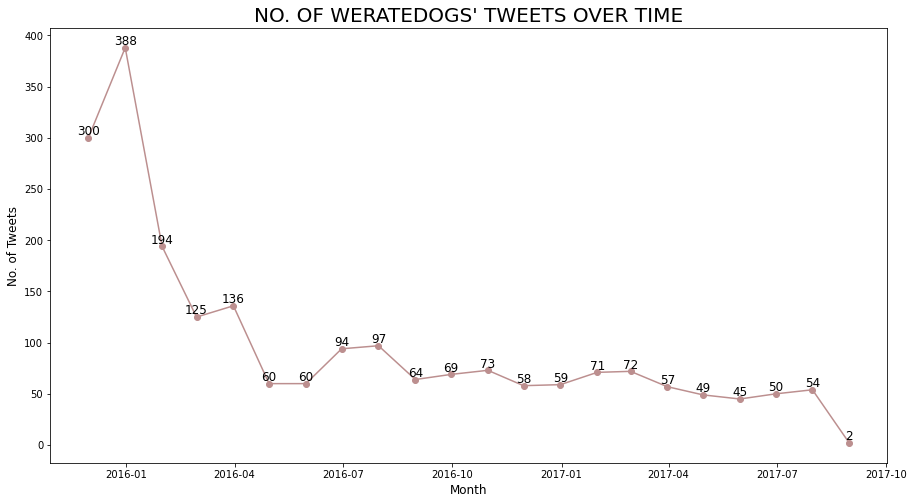

In [66]:
import matplotlib.pyplot as plt

x = df_monthly_tweet['timestamp']
y = df_monthly_tweet['tweet_id']

# creating the plot
fig, ax = plt.subplots(figsize = (15, 8))
plt.plot(x, y, marker = 'o', color = 'rosybrown')
plt.xlabel("Month", size = 12)
plt.ylabel("No. of Tweets", size = 12)
plt.title("NO. OF WERATEDOGS' TWEETS OVER TIME", size = 20)

# generating data labels
for index in range(len(x)):
  ax.text(x[index], y[index], y[index], size = 12, ha = 'center', va = 'bottom')
plt.show()

<i><b>Note:</b> the code above (on generating data labels) was referred to this [tutorial](https://towardsdatascience.com/how-to-label-the-values-plots-with-matplotlib-c9b7db0fd2e1).</i>
### 2. How were the engagements of WeRateDogs' tweets, over time?

In [67]:
# grouping favorite & retweet counts by timestamp and converting timestamp into month date 

monthly_rate = df.set_index('timestamp').groupby(pd.Grouper(freq = 'M')).sum().reset_index()
monthly_rate['timestamp'] = pd.to_datetime(monthly_rate['timestamp']).dt.date
df_monthly_rate = monthly_rate[['timestamp', 'favorite_count', 'retweet_count']]

In [68]:
# merging favorite & retweet counts data with tweet count datab

monthly_data = [df_monthly_tweet, df_monthly_rate]
df_monthly = reduce(lambda left, right: pd.merge(left, right, on = ['timestamp'], 
                                         how = 'left'), monthly_data)

In [69]:
df_monthly.head()

,timestamp,tweet_id,favorite_count,retweet_count
0,2015-11-30,300,369058,161371
1,2015-12-31,388,1369106,595698
2,2016-01-31,194,783806,307950
3,2016-02-29,125,508954,191096
4,2016-03-31,136,626981,235355


In [70]:
# calculating avg. favorites and retweets (favorites & retweets per tweet per month)

df_monthly['favorites_per_tweet'] = round((df_monthly['favorite_count'] / df_monthly['tweet_id']), 1)
df_monthly['retweets_per_tweet'] = round((df_monthly['retweet_count'] / df_monthly['tweet_id']),1)
df_monthly.head()

,timestamp,tweet_id,favorite_count,retweet_count,favorites_per_tweet,retweets_per_tweet
0,2015-11-30,300,369058,161371,1230.2,537.9
1,2015-12-31,388,1369106,595698,3528.6,1535.3
2,2016-01-31,194,783806,307950,4040.2,1587.4
3,2016-02-29,125,508954,191096,4071.6,1528.8
4,2016-03-31,136,626981,235355,4610.2,1730.6


In [71]:
mean = df_monthly[['favorites_per_tweet', 'retweets_per_tweet']].mean()
min = df_monthly[['favorites_per_tweet', 'retweets_per_tweet']].min()
max = df_monthly[['favorites_per_tweet', 'retweets_per_tweet']].max()

print (mean)
print (min)
print (max)

favorites_per_tweet    13964.131818
retweets_per_tweet     3941.786364 
dtype: float64
favorites_per_tweet    1230.2
retweets_per_tweet     537.9 
dtype: float64
favorites_per_tweet    36643.0
retweets_per_tweet     7683.5 
dtype: float64


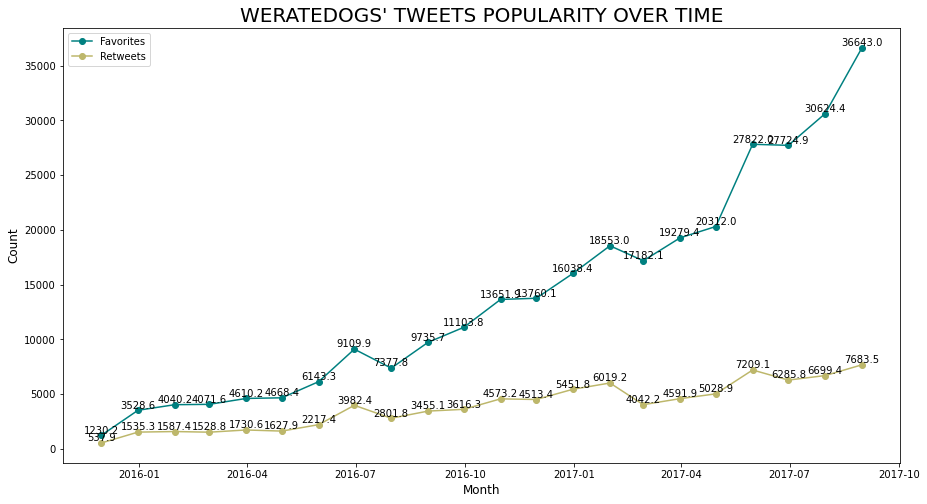

In [72]:
x = df_monthly['timestamp']
y = df_monthly['favorites_per_tweet']
z = df_monthly['retweets_per_tweet']

# creating the plot
fig, ax = plt.subplots(figsize = (15, 8))
plt.plot(x, y, marker = 'o', label = 'Favorites', color = 'teal')
plt.plot(x, z, marker = 'o', label = 'Retweets', color = 'darkkhaki')
plt.xlabel("Month", size = 12)
plt.ylabel("Count", size = 12)
plt.title("WERATEDOGS' TWEETS POPULARITY OVER TIME", size = 20)
plt.legend()

# generating data labels
for index in range(len(x)):
    ax.text(x[index], y[index], y[index], size = 10, ha = 'center', va = 'bottom')

for index in range(len(x)):
    ax.text(x[index], z[index], z[index], size = 10, ha = 'center', va = 'bottom')

plt.show()

### 3. Which dog was the most popular?
#### 3.1. Dog stage

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   tweet_id          2177 non-null   object             
 1   timestamp         2177 non-null   datetime64[ns, UTC]
 2   source            2177 non-null   object             
 3   text              2177 non-null   object             
 4   expanded_urls     2119 non-null   object             
 5   name              2177 non-null   object             
 6   jpg_url           1996 non-null   object             
 7   img_num           1996 non-null   float64            
 8   retweet_count     2177 non-null   int64              
 9   favorite_count    2177 non-null   int64              
 10  retweeted_status  2177 non-null   object             
 11  rating            2177 non-null   float64            
 12  stage             344 non-null    object             
 13  bre

In [74]:
stage_count = df.set_index('stage').groupby(['stage']).count().reset_index()
stage_count = stage_count[['stage', 'tweet_id']]

stage_rate = df.set_index('stage').groupby(['stage']).sum().reset_index()
stage_rate = stage_rate[['stage', 'favorite_count', 'retweet_count']]

stage_details = [stage_count, stage_rate]
stage_data = reduce(lambda left, right: pd.merge(left, right, on = ['stage'], 
                                         how = 'left'), stage_details)

stage_data

,stage,tweet_id,favorite_count,retweet_count
0,doggo,80,1378687,502516
1,floofer,10,116749,40836
2,pupper,229,1647401,562620
3,puppo,25,546777,171176


In [75]:
stage_data['favorite_per_tweet'] = round((stage_data['favorite_count'] / stage_data['tweet_id']), 1)
stage_data['retweet_per_tweet'] = round((stage_data['retweet_count'] / stage_data['tweet_id']), 1)

stage_data

,stage,tweet_id,favorite_count,retweet_count,favorite_per_tweet,retweet_per_tweet
0,doggo,80,1378687,502516,17233.6,6281.4
1,floofer,10,116749,40836,11674.9,4083.6
2,pupper,229,1647401,562620,7193.9,2456.9
3,puppo,25,546777,171176,21871.1,6847.0


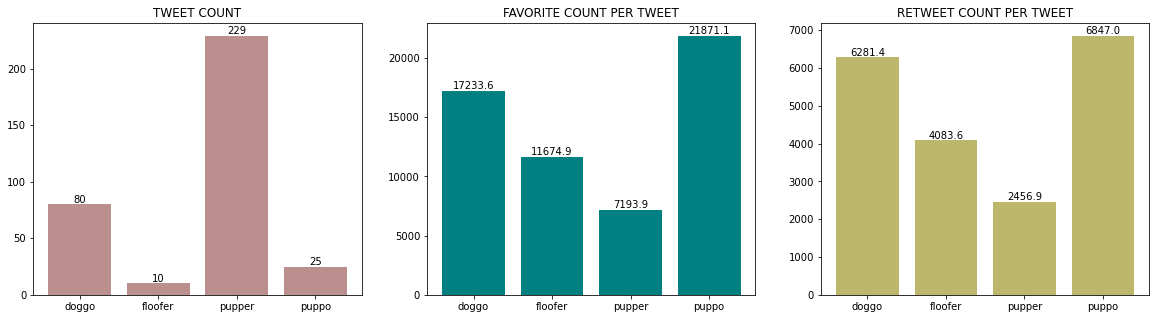

In [76]:
s = stage_data.stage
x = stage_data.tweet_id
y = stage_data.favorite_per_tweet
z = stage_data.retweet_per_tweet
        
def labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', va = 'bottom')
        
fig, ax = plt.subplots(figsize = (20, 5))
 
plt.subplot(1,3,1)
plt.bar(s, x, color = 'rosybrown')
labels(s, x)
plt.title('TWEET COUNT')

plt.subplot(1,3,2)
plt.bar(s, y, color = 'teal')
labels(s, y)
plt.title('FAVORITE COUNT PER TWEET')

plt.subplot(1,3,3)
plt.bar(s, z, color = 'darkkhaki')
labels(s, z)
plt.title('RETWEET COUNT PER TWEET')

plt.show()

In [77]:
breed_count = df.set_index('breed').groupby(['breed']).count().reset_index()
breed_count = breed_count[['breed', 'tweet_id']]

breed_rate = df.set_index('breed').groupby(['breed']).sum().reset_index()
breed_rate = breed_rate[['breed', 'favorite_count', 'retweet_count']]

breed_details = [breed_count, breed_rate]
breed_data = reduce(lambda left, right: pd.merge(left, right, on = ['breed'], 
                                         how = 'left'), breed_details)

breed_data.head()

,breed,tweet_id,favorite_count,retweet_count
0,afghan hound,3,51980,17928
1,airedale,12,63370,16725
2,american staffordshire terrier,16,150083,36973
3,appenzeller,2,14635,2916
4,australian terrier,2,22255,6157


In [78]:
breed_data['favorite_per_tweet'] = round((breed_data['favorite_count'] / breed_data['tweet_id']), 1)
breed_data['retweet_per_tweet'] = round((breed_data['retweet_count'] / breed_data['tweet_id']), 1)

breed_data

,breed,tweet_id,favorite_count,retweet_count,favorite_per_tweet,retweet_per_tweet
0,afghan hound,3,51980,17928,17326.7,5976.0
1,airedale,12,63370,16725,5280.8,1393.8
2,american staffordshire terrier,16,150083,36973,9380.2,2310.8
3,appenzeller,2,14635,2916,7317.5,1458.0
4,australian terrier,2,22255,6157,11127.5,3078.5
...,...,...,...,...,...,...
108,welsh springer spaniel,4,20224,4424,5056.0,1106.0
109,west highland white terrier,16,96876,23592,6054.8,1474.5
110,whippet,11,142026,53243,12911.5,4840.3
111,wire-haired fox terrier,2,17077,5847,8538.5,2923.5


In [79]:
breed_data.breed.nunique()

113

In [80]:
tweet_count = breed_data[['breed', 'tweet_id']].sort_values(by = 'tweet_id', ascending = False)[:5]
fav_count = breed_data[['breed', 'favorite_per_tweet']].sort_values(by = 'favorite_per_tweet', ascending = False)[:5]
rt_count = breed_data[['breed', 'retweet_per_tweet']].sort_values(by = 'retweet_per_tweet', ascending = False)[:5]

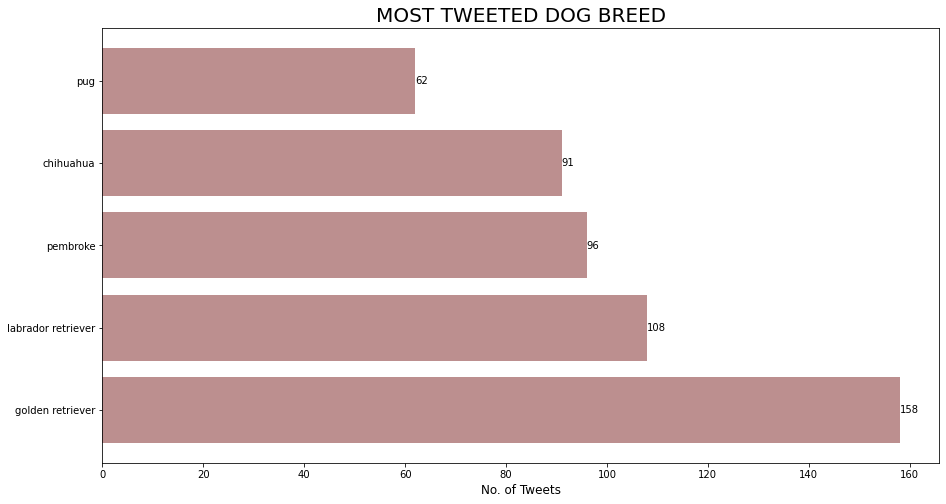

In [81]:
xtweet = tweet_count.breed
ytweet = tweet_count.tweet_id

fig, ax = plt.subplots(figsize = (15, 8))
bars = ax.barh(xtweet, ytweet, color = 'rosybrown') 

for bar in bars:
  width = bar.get_width()
  label_y_pos = bar.get_y() + bar.get_height() / 2
  ax.text(width, label_y_pos, s = f'{width}', va = 'center')

plt.xlabel('No. of Tweets', size = 12)
plt.title('MOST TWEETED DOG BREED', size = 20);

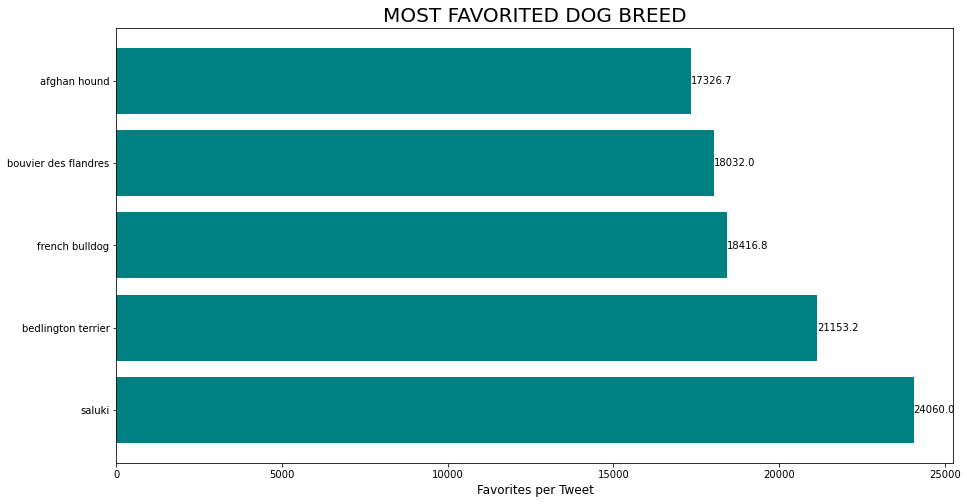

In [82]:
xfav = fav_count.breed
yfav = fav_count.favorite_per_tweet

fig, ax = plt.subplots(figsize = (15, 8))
bars = ax.barh(xfav, yfav, color = 'teal')

for bar in bars:
  width = bar.get_width()
  label_y_pos = bar.get_y() + bar.get_height() / 2
  ax.text(width, label_y_pos, s = f'{width}', va = 'center')

plt.xlabel('Favorites per Tweet', size = 12)
plt.title('MOST FAVORITED DOG BREED', size = 20);

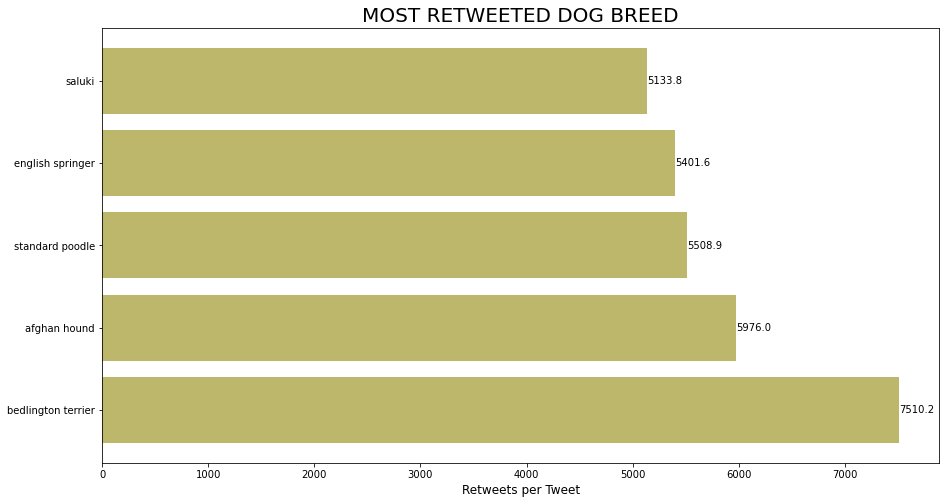

In [83]:
xrt = rt_count.breed
yrt = rt_count.retweet_per_tweet

fig, ax = plt.subplots(figsize = (15, 8))
bars = ax.barh(xrt, yrt, color = 'darkkhaki')

for bar in bars:
  width = bar.get_width()
  label_y_pos = bar.get_y() + bar.get_height() / 2
  ax.text(width, label_y_pos, s = f'{width}', va = 'center')

plt.xlabel('Retweets per Tweet', size = 12)
plt.title('MOST RETWEETED DOG BREED', size = 20);

<i><b>Note:</b> the three codes above were referred to this [article](https://towardsdatascience.com/how-to-make-bar-and-hbar-charts-with-labels-using-matplotlib-b701ce70ba9c#9082).</i>